# Modellbildung und Simulation - Übung 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pylab
import numpy.polynomial.polynomial as poly
from vpython import *

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Aufgabe 1 A - Fahrstuhl

Darstellung der gemessenen Daten aus dem Phyphox-Fahrstuhl-Experiment.

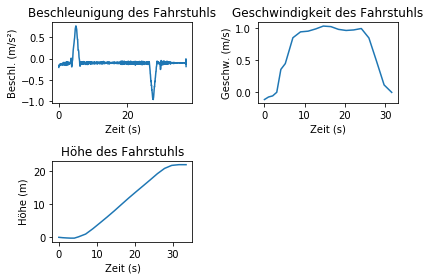

In [2]:
accData = pd.read_csv("data/Acceleration.csv", sep=";")
pvData = pd.read_csv("data/Pressure_and_velocity.csv", sep=";")

plt.subplot(221)
plt.title('Beschleunigung des Fahrstuhls')
plt.plot(accData['Time (s)'], accData['Acceleration (m/s²)'])
plt.ylabel('Beschl. (m/s²)')
plt.xlabel('Zeit (s)')
plt.subplot(222)
plt.title('Geschwindigkeit des Fahrstuhls')
plt.plot(pvData['Time (s)'], pvData['Velocity (m/s)'])
plt.ylabel('Geschw. (m/s)')
plt.xlabel('Zeit (s)')
plt.subplot(223)
plt.title('Höhe des Fahrstuhls')
plt.plot(pvData['Time (s)'], pvData['Height (m)'])
plt.ylabel('Höhe (m)')
plt.xlabel('Zeit (s)')
plt.tight_layout()

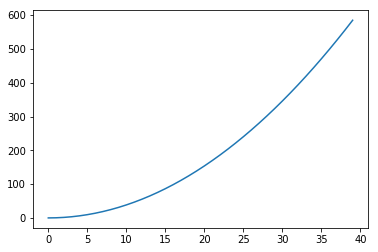

In [3]:
s_max = max(pvData['Height (m)'])
v_max = max(pvData['Velocity (m/s)'])
a_max = max(accData['Acceleration (m/s²)'])

S = lambda t: (1/2)*a_max*t*t;

plt.plot(range(0,40), [ S(x) for x in range(0,40) ])

Darstellung der Aufzugfahrt als Animation.

In [4]:
scene = canvas(background=color.white) #vpython bug
max_height = 22/2;
display(width=600,height=600,center=vector(max_height,0,0))
elev = box(pos=vector(0,-max_height,0),size=vector(1,1,1), mass=1.0,color=color.blue)
t = 0;
step = 0.02
end = 35;
while t < end:
    rate(100)
    elev.pos=vector(0,ffit_height(t)-max_height,0)
    t += step

<IPython.core.display.Javascript object>

NameError: name 'ffit_height' is not defined

# Aufgabe 1 B - Polyfit von Unbekannt

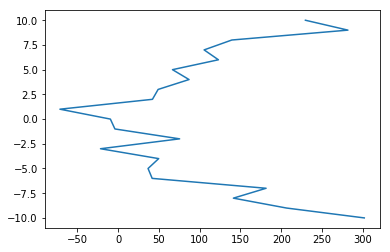

In [25]:
Unknown = pd.read_csv("data/UnbekannteDaten.txt", sep=" ")
plt.plot(Unknown['x'], Unknown['y'])

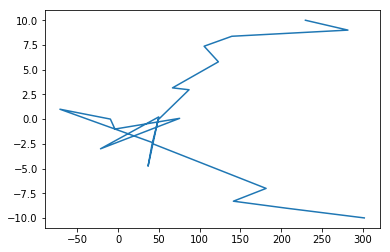

In [37]:
fit = pylab.polyfit(Unknown['x'], Unknown['y'], 17)
fit_fn = pylab.poly1d(fit)
plt.plot(Unknown['x'], fit_fn(Unknown['x']))

## Aufgabe 1 C - Federkonstanten

Einlesen der Federdaten und Darstellung der Auslenkung der Feder abhängig vom befestigten Gewicht

In [ ]:
SpringData = pd.read_csv("data/DatenFeder.txt", sep=" ")

In [ ]:
plt.plot(SpringData['Mass(kg)'], SpringData['Distance(m)'])

Schätzen eines Polynoms anhand der Federdaten, Polynom vom Grad 15 liefert ausreichende Annäherung.

In [ ]:
coefs = poly.polyfit(SpringData['Mass(kg)'], SpringData['Distance(m)'], 15)
ffit = poly.Polynomial(coefs)    # instead of np.poly1d
plt.plot(SpringData['Mass(kg)'], ffit(SpringData['Mass(kg)']))

Berechnung der Federkonstante über die Formel D = F/x für jeden Datenpunkt(Gewicht und Auslenkung der Feder). Aus den berechneten Federkonstanten wird der Mittelwert berechnet.

In [ ]:
SpringConst = 0;
for i in range(0,19):
    Force = SpringData['Mass(kg)'][i] * 9.80665
    SpringConst = SpringConst + (Force / SpringData['Distance(m)'][i])
    #print((Kraft / FederData['Distance(m)'][i]))
SpringConst = SpringConst / 18
print('Die gemittelte Federkonstante aus linearer Funktion ist: ' + str(SpringConst))

In [ ]:
D = poly.polyfit(SpringData['Distance(m)'][0:19],SpringData['Mass(kg)'][0:19] * 9.80665,3);
D   #????

## Aufgabe 1 D - Wurfbewegung

Einlesen der Daten eines geworfenen Balls, der in bestimmten Abständen in Höhe und Distanz beobachtet wurde. Umrechnung der Einheiten von yds in Meter.

In [ ]:
ThrowData = pd.read_csv("data/DatenSchWurf.txt", sep=" ")
ThrowData = ThrowData * 0.9144
ThrowData

Darstellung der Flugbahn des geworfenen Balls.

In [ ]:
plt.plot(ThrowData['Distance(yds)'], ThrowData['height(ins)'])

Schätzen eines Polynoms durch lineare Regression aus den gegebenen Wurfdaten. Polynom vom Grad 2 ausreichend da Wurfform Parabelförmig.

In [ ]:
coeffs = poly.polyfit(ThrowData['Distance(yds)'],ThrowData['height(ins)'],2);
ffit = poly.Polynomial(coeffs)    # instead of np.poly1d
plt.plot(ThrowData['Distance(yds)'], ffit(ThrowData['Distance(yds)']))

Berechnung der Flugzeit über die ausschließliche Betrachtung des vertikalen freien Falls. Die Dauer des freien Falls vom höchsten Punkt der Flugbahn bis zum Boden wird über die Formel t = (s*2/g)^0.5 berechnet, wobei s die Höhe des freien Falls ist und g die Gravitationskonstante auf der Erde. Es wird, aufgrund der Parabelförmigen Flugbahn und der Annahme dass der Ball in gleichmäßigen Abständen beobachtet wurde, angenommen dass die Zeit vom Abwurf bis zum höchsten Punkt der Flugbahn in etwa gleichlang ist wie die in der der Ball fällt. Somit muss oben berechnete Zeit t verdoppelt werden um die gesamte Flugzeit zu erhalten.

In [ ]:
#Dauer des Flugs: Freier Fall aus 20m Höhe Formel s = 1/2 g * t^2 
g = 9.81;
s = max(ThrowData['height(ins)']);
t=(s*2/g)**0.5
t = t * 2 #Ball fliegt in etwa in der gleichen Geschwindigkeit nach oben wie er wieder fällt
print('Die Flugzeit beträgt ca. ' + str(t) + ' Sekunden')


Die horizontale Geschwindigkeit wird aus der zurückgelegten Entfernung sowie der gerade berechneten Flugzeit berechnet.

In [ ]:
#Geschwindigkeit in horzontaler Richtung
vHoriz = max(ThrowData['Distance(yds)']) / t
print('Die Horizontale Geschwindigkeit beträgt: ' + str(vHoriz) + ' m/s')

Die vertikale Fluggeschwindigkeit ist abhängig vom Zeitpunkt des Fluges. Sie wird wieder zunächst für den freien Fall über die Formel v = g * t berechnet. Durch die Parabelform wird angenommen, dass sich die Geschwindigkeit auf dem Flug von unten nach oben genauso verhalten hat wie beim freien Fall, die Werte werden also umgekehrt wie beim freien Fall hinzugefügt. 

In [ ]:
step = t / max(ThrowData['Distance(yds)'])
g = 9.81
v = []
vDown = []
vUp = []
for i in range(0, 14):
    vDown.append(g*(step * i))
vUp = vDown[::-1]
vUp.pop()
v = vUp + vDown
plt.plot(range(0,27), v)

